## Chapter 05. Regression with Pytorch(Lab)
### Lab2. Pytorch Regression (Linear Regression vs MLP)



### Install Pytorch (For Google Colab)

In [1]:
#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

     |████████████████████████████████| 591.8 MB 658 bytes/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 60.1 MB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 22.1 MB 99.3 MB/s 
     |████████████████████████████████| 17.4 MB 397 kB/s 
     |████████████████████████████████| 17.3 MB 121 kB/s 
     |████████████████████████████████| 12.8 MB 54.0 MB/s 
     |████████████████████████████████| 12.7 MB 22.5 MB/s 
     |████████████████████████████████| 11.8 MB 76.5 MB/s 
     |████████████████████████████████| 5.9 MB 55.2 MB/s 
     |████████████████████████████████| 6.6 MB 26.7 MB/s 
     |████████████████████████████████| 6.6 MB 30.2 MB/s 
     |████████████████████████████████| 4.0 MB 50.6 MB/s 
     |████████████████████████████████| 10.2 MB 25.3 MB/s 
     |████████████████████████████████| 10.1 MB 27.2 MB/s 
     |████████████████████████████████| 8.8 MB 29.5 MB/s 
   

### 1. Data Generation  (Preparation)

- X(input): 2차원,  continuous space 분포 / Y(Class): 1차
- 위의 분포에서 관측시 발생한 오차 $e$를 더해져 있는 상황

<br>

$$ e \sim \mathcal{N} (0, 0.5) $$
$$ y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  

<br>

- 실습 문제: 2차원 입력데이터로 y의 분포를 예측(regression)

<br>
**Data Set**  <br>
- 총 2400개 중 train 1600개 / validatino 400개 / test 400개

$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

- 데이터 시각화(x, y 데이터 3D 공간)

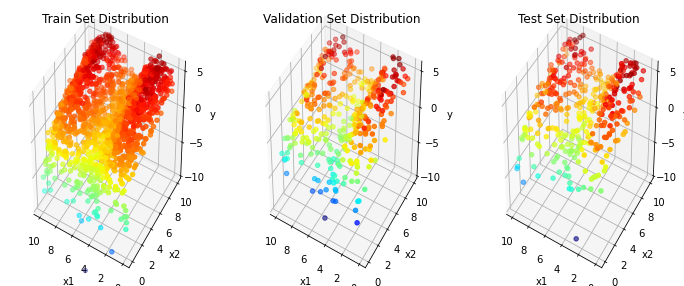

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


## (1) Generating Dataset
num_data = 2400                             # data 개수
x1 = np.random.rand(num_data) * 10          # x1 데이터 생성(x1의 range: 0 ~ 10)
x2 = np.random.rand(num_data) * 10          # x2 데이터 생성(x2의 range: 0 ~ 10)
e = np.random.normal(0, 0.5, num_data)      # 오차 생성
X = np.array([x1, x2]).T                    # input vector 생성
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e    # 정답 y 값 생성

## (2) Split the Dataset(Train, Validation, Test) 
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

## (3) Visualization data
# 3.1 Train set 분포
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d') # 3차원으로 시각화
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet') # 색깔: y 값(값이 진할수록[빨강색] 높음)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

# 3-2. validation set 분포
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

# 3.3 Test set 분포
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)  
- Linear Rgression 시 nn.Linear를 통해 구현(H(x) = Wx + b)
- in_features: input x 차원 / out_features: ouput y 차원

**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$

In [3]:
import torch
import torch.nn as nn

class LinearModel(nn.Module): # LinearModel 선언(Linear regressoin 모델 Calss)
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True) # input(2차원 = in_features, 입력 차원) / output(out_features, class 차
    
    def forward(self, x): # forward 선언(linear 선언) # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴
        return self.linear(x)

### 3. Cost Function Define (Loss Function Define)  

- Pytorch 내부에 구현되어 있는 function 활용
- Regression: MSE Loss
- https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.htm

In [4]:
reg_loss = nn.MSELoss()

# uncomment for testing Loss Function
test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))

tensor(0.5000)
tensor(0.)


### 4. Train & Evaluation

Pytorch 내 
- loss.backward() 기능: parameter에 대한 loss 편미분 자동 계산
- optimizer.step()기능: Gradient 바탕으로 parameter 값을 updata
- 모델 내에서 Train data 학습 -> validation set를 넣고 loss 비교
- Regression Task(Metrix: MAE)

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

In [5]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error


# 1. Construction Model
model = LinearModel()      # model 선언(linear regression)
print(model.linear.weight) # model weight 확인
print(model.linear.bias)   # model bias 확인

print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 모델 내의 학습 parameter 수 counting

# 2. Constrruction Optimizer
lr = 0.005  # learning rate(Hyperparameter / 학습률)
optimizer = optim.SGD(model.parameters(), lr = lr) # Optimizer: SGD(model Parameter + learning rate)
epoch = 4000 # 학습 횟수(epoch)

## 학습 단계 epoch별 loss 및 Metrix(MAE loss)를 저장할 list 생성
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []

Parameter containing:
tensor([[-0.5130, -0.5736]], requires_grad=True)
Parameter containing:
tensor([-0.6317], requires_grad=True)
3 parameters


In [6]:
# 3. Model 학습
for i in range(epoch):

    # 3.1 Model train
    model.train()         # Model Train setting 
    optimizer.zero_grad() # optimizer 초기화(Gradient = 0으로 초기화).
    
    ## Train 데이터 입력  
    input_x = torch.Tensor(train_X)       
    true_y = torch.Tensor(train_y)        # target 값 long(정수)
    pred_y = model(input_x)               # model prediction
    
    ## loss 계산
    loss = reg_loss(pred_y.squeeze(), true_y) # loss 계산(앞선 정의한 loss function / crossentropy) / whu? squeeze 
    loss.backward()                           # Gradient 계산.
    optimizer.step()                          # Gradient(backward) 기준으로 parameter updata / learning rate 만큼 updata 

    ## 학습 과정 결과 저장(loss & accuracy)
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy()) # loss 자체 형식: "tensor(1.0518, grad_fn=<NllLossBackward>) -> 연산 기록을 분리(Tensor가 기록 추적 중단) 후 numpy 형식 저장"
    
    
    # 3.2 model 검증 
    model.eval()          # Model test setting
    optimizer.zero_grad() # optimizer 초기화(상동)

    ## Validation data 입력
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   

    ## loss 계산(train과 다른점: Gradient 계산 및 parameter updata가 진행 안됨)
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # 3.3 Modlel 평가 / 3.4 학습 과정 visualization
    if i % 200 == 0:  # epoch: 200별로 데이터 분포와 모델이 예측한 분포 시각화
        
        ## 모델 평가(Metrix)
        model.eval()
        optimizer.zero_grad()

        ## Test data 입력
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)

        ##  model(input_x).detach(): 각 데이터별로 loss 값
        pred_y = model(input_x).detach().numpy() 

        ## mae 계산 / 주의할점: (sklearn 쪽 함수) true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것
        mae = mean_absolute_error(true_y, pred_y)
        list_mae.append(mae)                     # epoch별 mae 
        list_mae_epoch.append(i)                 # epoch 저장
        
        ## 시각화
        fig = plt.figure(figsize=(15,5))
        
        ## 3.4.1 실제 값(y) Visualization
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        ## 3.4.2 test 예측 값(y_hat) Visualization
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ## 3.4.3 train 예측 값(y_hat) Visualization
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

Output hidden; open in https://colab.research.google.com to view.

### 5. Report Experiment  
1. 학습 과정에서 epoch별 train과 validation loss 시각화(과적합 여부 판단)
- valdation loss가 증가하기 시작하면 -> 과적합 
학습 과정에서 기록했던 train_loss와 val_loss를 그려보기 

2. epoch별 Accuracy(MAE metric) 시각화

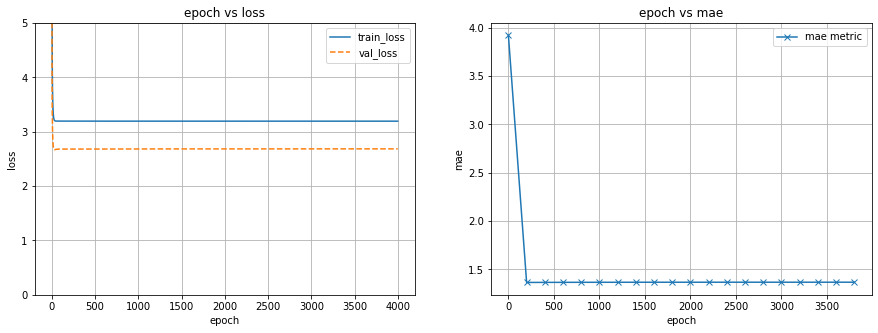

In [7]:
fig = plt.figure(figsize=(15,5))

# Loss function Visualization
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')       # epoch별 train loss 변화 시각화
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')     # epoch별 validation loss 변화 시각화
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# epoch별 mae 변화: mae 어느정도 수렴하는 것 확인
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()